## Практическое задание к курсу

<ol>
    <li>Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.</li>
    <li>Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 
    </li>


</ol>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

**Строим слой семплирования sampling layer**

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a picture."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Строим энкодер encoder**

In [4]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

**Строим свой decoder**

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

**Создаем класс модель по Model с особым шагом обучения train_step**

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

**Учим VAE**

In [8]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_images = np.concatenate([x_train, x_test], axis=0)
mnist_images = np.expand_dims(mnist_images, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_images, epochs=20, batch_size=128)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/20
547/547 [==============================] - 38s 9ms/step - loss: 324.8883 - reconstruction_loss: 319.4650 - kl_loss: 5.4233
Epoch 2/20
547/547 [==============================] - 5s 9ms/step - loss: 277.4055 - reconstruction_loss: 272.5478 - kl_loss: 4.8578
Epoch 3/20
547/547 [==============================] - 5s 9ms/step - loss: 272.1485 - reconstruction_loss: 267.7428 - kl_loss: 4.4057
Epoch 4/20
547/547 [==============================] - 5s 9ms/step - loss: 269.6980 - reconstruction_loss: 265.4694 - kl_loss: 4.2286
Epoch 5/20
547/547 [==============================] - 5s 9ms/step - loss: 268.0398 - reconstruction_loss: 263.9003 - kl_loss: 4.1395
Epoch 6/20
547/547 [==============================] - 5s 9ms/step - loss: 266.7487 - reconstruction_loss: 262.6725 - kl_loss: 4.0762
Epoch 7/20
547/547 [==============================] - 5s 9ms/step - loss: 265.8640 - reconstruction_loss: 261.8298 - kl_loss: 4.0341
Epoch

In [9]:
vae.fit(mnist_images, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 5s 9ms/step - loss: 260.2970 - reconstruction_loss: 256.4743 - kl_loss: 3.8227
Epoch 2/20
547/547 [==============================] - 5s 9ms/step - loss: 260.1678 - reconstruction_loss: 256.3414 - kl_loss: 3.8264
Epoch 3/20
547/547 [==============================] - 5s 9ms/step - loss: 259.8895 - reconstruction_loss: 256.0591 - kl_loss: 3.8305
Epoch 4/20
547/547 [==============================] - 5s 9ms/step - loss: 259.6417 - reconstruction_loss: 255.8319 - kl_loss: 3.8098
Epoch 5/20
547/547 [==============================] - 5s 9ms/step - loss: 259.6062 - reconstruction_loss: 255.8070 - kl_loss: 3.7992
Epoch 6/20
547/547 [==============================] - 5s 9ms/step - loss: 259.3873 - reconstruction_loss: 255.5897 - kl_loss: 3.7977
Epoch 7/20
547/547 [==============================] - 5s 9ms/step - loss: 259.0574 - reconstruction_loss: 255.2726 - kl_loss: 3.7848
Epoch 8/20
547/547 [==============================] - 5s 9ms/step - l

**Результат предсказания для предмета**

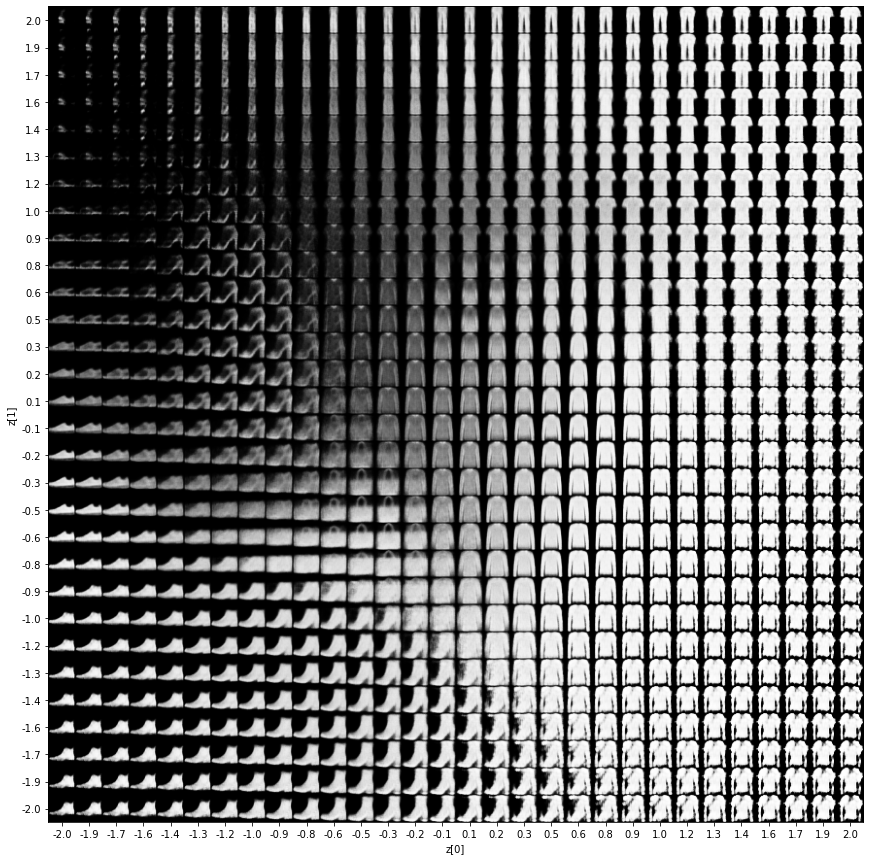

In [10]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

**Посмотрим на кластеры в скрытом пространстве**

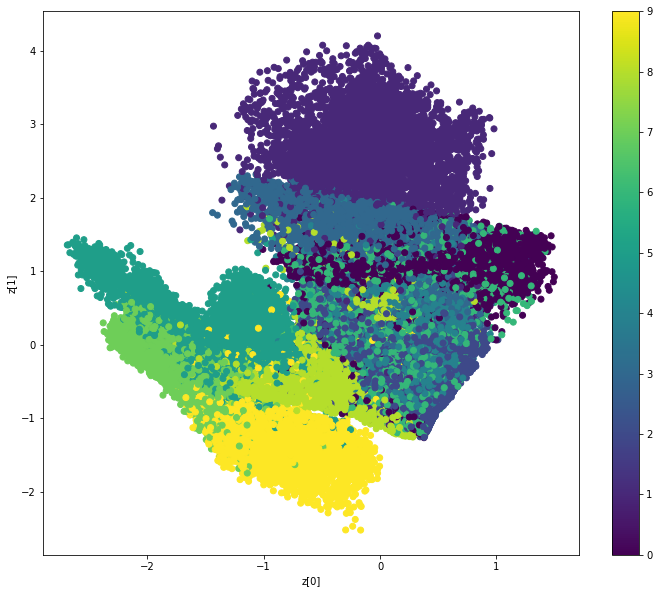

In [11]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

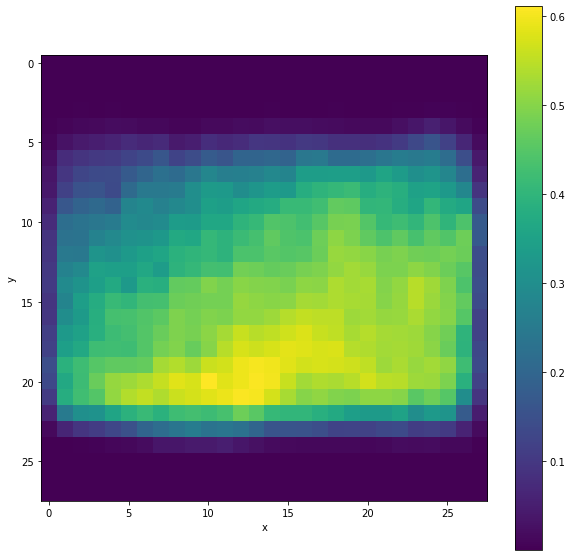

In [12]:
def plot_item_from_decoder(decoder, z, item_size):
    # display a 2D plot of the item classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    item = decoder.predict(data)
    item = item.reshape(item_size, item_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(item)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_item_from_decoder(decoder, [-1,-0.5], 28)

**Исходя из проделанной работы можно сделать выводы:**
1. С увеличением количества эпох - растет результат, но при уменьшении batch все происходит вплоть да наоборот, результат значительно падает.
2. При увеличении размера batch качество повышается, но это может быть переобучение

## 2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. 

Источник - источник: https://www.sciencedirect.com/topics/engineering/deep-belief-network

**Deep Belief Networks (DBNs)**

DBN представляют собой стек машин Больцмана со связями между слоями, причем каждый слой RBM взаимодействует как с предыдущим, так и с последующим слоями. Глубокие сети доверия (DBN) используются для распознавания изображений, видео и данных захвата движения. 

Принцип работы:
1. Алгоритм жадного обучения использует послойный подход для обучения генеративных весов сверху вниз
2. Выполняются этапы выборки Гиббса на двух верхних скрытых слоях. На этом этапе берется выборка из RBM, определяемого двумя верхними скрытыми слоями
3. Делается выборка из видимых единиц, используя один проход выборки предков по остальной части модели
4. Обучается тому, что значения скрытых переменных в каждом слое могут быть определены одним проходом снизу вверх